# <center><u> GRU - House 10 with Exogenous Variables

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv

load_dotenv()

db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [3]:
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [72]:
query="""
    select * 
    from agg.tidy_data_30min
    where site = 20
"""

In [73]:
df = pd.read_sql_query(query, conn)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_9250/1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [74]:
# Convert 'ts' to datetime and set as index
# df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.set_index('timestamp', drop=False)
df = df.sort_index()

df

,timestamp,site,year,month,day,hour,minute,day_of_week,season,net_load,...,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,2019-04-01 00:00:00+00:00,20,2019,4,1,1,0,0,2,198.79,...,2.0,87.0,12.0,0.0,0.0,152.86,15.4150,138.56,18.69,0
2019-04-01 00:30:00+00:00,2019-04-01 00:30:00+00:00,20,2019,4,1,1,30,0,2,250.51,...,2.0,87.0,12.0,0.0,0.0,204.52,15.3175,166.11,18.60,0
2019-04-01 01:00:00+00:00,2019-04-01 01:00:00+00:00,20,2019,4,1,2,0,0,2,194.07,...,3.0,89.0,11.0,0.0,0.0,214.66,15.8375,179.70,31.03,0
2019-04-01 01:30:00+00:00,2019-04-01 01:30:00+00:00,20,2019,4,1,2,30,0,2,245.33,...,3.0,89.0,11.0,0.0,0.0,209.72,15.8775,177.33,52.99,0
2019-04-01 02:00:00+00:00,2019-04-01 02:00:00+00:00,20,2019,4,1,3,0,0,2,223.68,...,4.0,91.0,11.0,0.0,0.0,230.59,16.3350,212.62,65.21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,2020-03-31 20:30:00+00:00,20,2020,3,31,21,30,1,2,28.10,...,NaN,NaN,NaN,NaN,NaN,282.00,15.4650,264.64,19.82,0
2020-03-31 21:00:00+00:00,2020-03-31 21:00:00+00:00,20,2020,3,31,22,0,1,2,11.10,...,NaN,NaN,NaN,NaN,NaN,321.01,14.5975,220.50,16.55,0
2020-03-31 21:30:00+00:00,2020-03-31 21:30:00+00:00,20,2020,3,31,22,30,1,2,196.48,...,NaN,NaN,NaN,NaN,NaN,353.42,14.7625,206.66,30.23,0


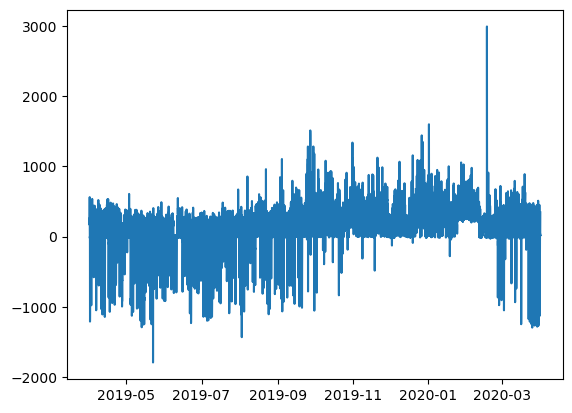

In [75]:
plt.plot(df.index, df.net_load)
plt.show()

In [76]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))

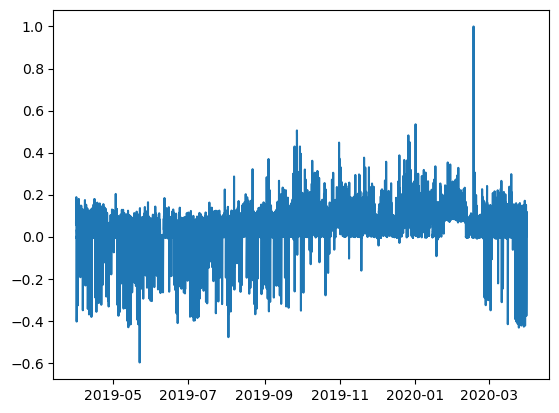

In [77]:
plt.plot(df.index, df.net_load_norm)
plt.show()

## <u> Dataset Preparation

In [66]:
##Parameters

#n_input = no. of time steps considered before making the prediction
#n_features = no. of variables/features considered
#n_output = no. of time steps to forecast

# Note: 1 time step = 30 mins
# Look at the last two weeks to forecast the next 36 hours

# 1 day = 2 * 24 * 1 = 24
# 2 hours = 2 * 2 = 8 

n_input = 144
n_features = 12
n_output = 72


# Select which features are to be inputted into the LSTM i.e., which columns in the df
df_input = df[['net_load_norm','month', 'day', 'hour', 'day_of_week', 'season', 'avg_net_load','weekend_or_bank_holiday','solar_radiation','sunshine_duration']]
df_input

,net_load_norm,month,day,hour,day_of_week,season,avg_net_load,weekend_or_bank_holiday,solar_radiation,sunshine_duration
timestamp,,,,,,,,,,
2019-04-01 00:00:00+00:00,0.066453,4,1,1,0,2,152.86,0,0.0,0.0
2019-04-01 00:30:00+00:00,0.083742,4,1,1,0,2,204.52,0,0.0,0.0
2019-04-01 01:00:00+00:00,0.064875,4,1,2,0,2,214.66,0,0.0,0.0
2019-04-01 01:30:00+00:00,0.082010,4,1,2,0,2,209.72,0,0.0,0.0
2019-04-01 02:00:00+00:00,0.074773,4,1,3,0,2,230.59,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,0.009393,3,31,21,1,2,282.00,0,NaN,NaN
2020-03-31 21:00:00+00:00,0.003711,3,31,22,1,2,321.01,0,NaN,NaN
2020-03-31 21:30:00+00:00,0.065681,3,31,22,1,2,353.42,0,NaN,NaN


In [54]:
df_input['sunshine_duration(t+48)'] = df_input['sunshine_duration'].shift(-48) #Add prediction for time the day after
df_input['solar_radiation(t+48)'] = df_input['solar_radiation'].shift(-48)
df_input


/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_9250/2540985396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['sunshine_duration(t+48)'] = df_input['sunshine_duration'].shift(-48) #Add prediction for time the day after
/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_9250/2540985396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['solar_radiation(t+48)'] = df_input['solar_radiation'].shift(-48)


,net_load_norm,month,day,hour,day_of_week,season,avg_net_load,weekend_or_bank_holiday,solar_radiation,sunshine_duration,sunshine_duration(t+48),solar_radiation(t+48)
timestamp,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,0.066453,4,1,1,0,2,152.86,0,0.0,0.0,0.0,0.0
2019-04-01 00:30:00+00:00,0.083742,4,1,1,0,2,204.52,0,0.0,0.0,0.0,0.0
2019-04-01 01:00:00+00:00,0.064875,4,1,2,0,2,214.66,0,0.0,0.0,0.0,0.0
2019-04-01 01:30:00+00:00,0.082010,4,1,2,0,2,209.72,0,0.0,0.0,0.0,0.0
2019-04-01 02:00:00+00:00,0.074773,4,1,3,0,2,230.59,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,0.009393,3,31,21,1,2,282.00,0,NaN,NaN,NaN,NaN
2020-03-31 21:00:00+00:00,0.003711,3,31,22,1,2,321.01,0,NaN,NaN,NaN,NaN
2020-03-31 21:30:00+00:00,0.065681,3,31,22,1,2,353.42,0,NaN,NaN,NaN,NaN


In [55]:
df_input.isnull().sum()

net_load_norm                0
month                        0
day                          0
hour                         0
day_of_week                  0
season                       0
avg_net_load                 0
weekend_or_bank_holiday      0
solar_radiation            494
sunshine_duration          494
sunshine_duration(t+48)    542
solar_radiation(t+48)      542
dtype: int64

In [58]:
df_input.index = pd.to_datetime(df_input.index, utc=True)

# Group the DataFrame by the hour and minute of the day and calculate the mean for each hour-minute combination
hourly_mean = df_input.groupby([df_input.index.hour, df_input.index.minute]).mean()

# Define a function to fill missing values with the mean for that hour-minute combination
def fill_na_with_hourly_mean(row):
    hour = row.name.hour
    minute = row.name.minute
    return hourly_mean.loc[(hour, minute)]

# Apply the fill_na_with_hourly_mean function to fill missing values
df_input = df_input.apply(lambda row: fill_na_with_hourly_mean(row) if pd.isna(row).any() else row, axis=1)

In [59]:
df_input.isnull().sum()

net_load_norm              0
month                      0
day                        0
hour                       0
day_of_week                0
season                     0
avg_net_load               0
weekend_or_bank_holiday    0
solar_radiation            0
sunshine_duration          0
sunshine_duration(t+48)    0
solar_radiation(t+48)      0
dtype: int64

In [60]:
df_input

,net_load_norm,month,day,hour,day_of_week,season,avg_net_load,weekend_or_bank_holiday,solar_radiation,sunshine_duration,sunshine_duration(t+48),solar_radiation(t+48)
timestamp,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,0.066453,4.000000,1.000000,1.0,0.000000,2.0,152.860000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-01 00:30:00+00:00,0.083742,4.000000,1.000000,1.0,0.000000,2.0,204.520000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-01 01:00:00+00:00,0.064875,4.000000,1.000000,2.0,0.000000,2.0,214.660000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-01 01:30:00+00:00,0.082010,4.000000,1.000000,2.0,0.000000,2.0,209.720000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-01 02:00:00+00:00,0.074773,4.000000,1.000000,3.0,0.000000,2.0,230.590000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,0.068494,6.513661,15.756831,21.0,2.986339,2.5,277.816858,0.284153,0.373596,1.578652,1.583099,0.374648
2020-03-31 21:00:00+00:00,0.079512,6.513661,15.756831,22.0,2.986339,2.5,260.204836,0.284153,0.000000,0.000000,0.000000,0.000000
2020-03-31 21:30:00+00:00,0.075038,6.513661,15.756831,22.0,2.986339,2.5,282.622486,0.284153,0.000000,0.000000,0.000000,0.000000


In [69]:
#Scale Average Net Load
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_input['avg_net_load'] = scaler.fit_transform(df_input[['avg_net_load']])
df_input.rename(columns={'net_load_norm': 'net_load'}, inplace=True)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_9250/2892821050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['avg_net_load'] = scaler.fit_transform(df_input[['avg_net_load']])
/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_9250/2892821050.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.rename(columns={'net_load_norm': 'net_load'}, inplace=True)


In [70]:
df_input

,net_load,month,day,hour,day_of_week,season,avg_net_load,weekend_or_bank_holiday,solar_radiation,sunshine_duration
timestamp,,,,,,,,,,
2019-04-01 00:00:00+00:00,0.066453,4,1,1,0,2,0.959199,0,0.0,0.0
2019-04-01 00:30:00+00:00,0.083742,4,1,1,0,2,0.960635,0,0.0,0.0
2019-04-01 01:00:00+00:00,0.064875,4,1,2,0,2,0.960917,0,0.0,0.0
2019-04-01 01:30:00+00:00,0.082010,4,1,2,0,2,0.960780,0,0.0,0.0
2019-04-01 02:00:00+00:00,0.074773,4,1,3,0,2,0.961360,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,0.009393,3,31,21,1,2,0.962789,0,NaN,NaN
2020-03-31 21:00:00+00:00,0.003711,3,31,22,1,2,0.963873,0,NaN,NaN
2020-03-31 21:30:00+00:00,0.065681,3,31,22,1,2,0.964774,0,NaN,NaN


In [71]:
X, y = [], []
for i in range(len(df_input) - n_input - n_output + 1):
    # Select all columns for the input sequence
    X.append(df_input.iloc[i:(i + n_input)].values)  
    
    y.append(df_input['net_load'].iloc[(i + n_input):(i + n_input + n_output)].values)

X = np.array(X).reshape((len(X), n_input, -1))  
y = np.array(y)

In [68]:
df_input

,net_load_norm,month,day,hour,day_of_week,season,avg_net_load,weekend_or_bank_holiday,solar_radiation,sunshine_duration
timestamp,,,,,,,,,,
2019-04-01 00:00:00+00:00,0.066453,4,1,1,0,2,152.86,0,0.0,0.0
2019-04-01 00:30:00+00:00,0.083742,4,1,1,0,2,204.52,0,0.0,0.0
2019-04-01 01:00:00+00:00,0.064875,4,1,2,0,2,214.66,0,0.0,0.0
2019-04-01 01:30:00+00:00,0.082010,4,1,2,0,2,209.72,0,0.0,0.0
2019-04-01 02:00:00+00:00,0.074773,4,1,3,0,2,230.59,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,0.009393,3,31,21,1,2,282.00,0,NaN,NaN
2020-03-31 21:00:00+00:00,0.003711,3,31,22,1,2,321.01,0,NaN,NaN
2020-03-31 21:30:00+00:00,0.065681,3,31,22,1,2,353.42,0,NaN,NaN
